* 분류기 집합은 개별 분류기보다 더 뛰어난 예측 성능을 내는 경우가 많다.

### 이 장의 주요 목표
* 다수결 투표를 기반으로 예측 만들기
* 중복을 허용하여 랜덤하게 훈련 샘플을 뽑는 배깅을 사용해서 과대적합 감소하기
* 앞선 모델의 오차를 학습하는 약한 학습기로 구성된 부스팅으로 강력한 모델 구축하기

### 앙상블 학습
여러 분류기를 하나의 메타 분류기로 연결하여 개별 분류기보다 더 좋은 일반화 성능을 달성하는 것.
* 과반수 투표 : 과반수 투표는 분류기의 과반수가 예측한 클래스 레이블을 선택하는 단순한 방법이다. 다중 클래스 문제에는 다수결 투표.
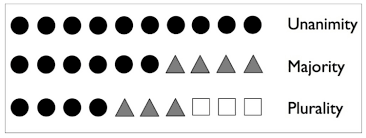
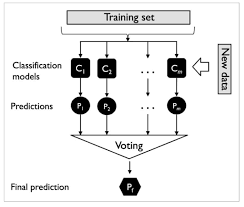

* 에러율이 0.25인 분류기 11개로 구성된 앙상블의 에러율은 다음과 같다!
![텍스트](https://blog.kakaocdn.net/dn/FFNcj/btqCtXAKCDP/kbeHVb7ChOT39hru8YSHFk/img.png)

In [1]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error ** k *(1-error) **(n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier=11, error = 0.25)


0.03432750701904297

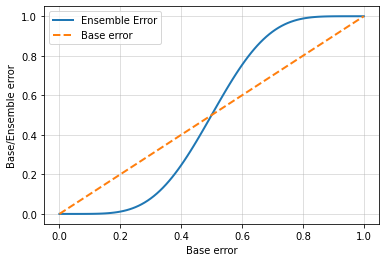

In [2]:
# error [0.0, 1.0]

import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier =11, error= error) for error in error_range]

plt.plot(error_range, ens_errors, label = 'Ensemble Error', linewidth= 2)
plt.plot(error_range, error_range, ls='--', label='Base error', lw =2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc = 'upper left')
plt.grid(alpha = 0.5)
plt.show()

* 결과 그래프에서 볼 수 있듯이 앙상블의 에러 확률은 개별 분류기보다 항상 좋다. 다만 개별 분류기의 에러율이 0.5보다 작아야 한다.

### 다수결 투표를 사용한 분류 앙상블

In [3]:
# 가중치가 적용된 다수결 투표
import numpy as np
ex = np.array([[0.9, 0.1],
             [0.8, 0.2],
             [0.4, 0.6]])
p = np.average(ex, axis = 0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [4]:
np.argmax(p)

0

In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
'''from sklearn.externals import six'''
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
import six

In [6]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote = 'classlabel', weights = None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X,y):
        self.lablenc_ =LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
            
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
            
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights = self.weights)),
                                          axis = 1,
                                          arr = predictions)
            
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis = 0, weights = self.weights)
        return avg_proba
    
    def get_params(self, deep = True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out
        

### 다수결 투표 방식을 사용하여 예측 만들기

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [8]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size =0.5,
                                                   random_state =1,
                                                   stratify=y)

훈련 세트를 사용하여 서로 다른 세 개의 분류기를 훈련합니다
* 로지스틱 회귀 분류기
* 결정 트리 분류기
* K-최근접 이웃 분류기

In [10]:
# 각 분류기를 앙상블로 묶기 전에 훈련 세트에서 10-겹 교차 검증 성능평가
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

In [11]:
clf1 = LogisticRegression(solver = 'liblinear', penalty='l2',C=0.001,
                        random_state = 1)
clf2 = DecisionTreeClassifier(max_depth =1, criterion = 'entropy',
                             random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p=2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print('ROC AUC : %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC : 0.92 (+/- 0.15) [Logistic regression]
ROC AUC : 0.87 (+/- 0.18) [Decision tree]
ROC AUC : 0.85 (+/- 0.13) [KNN]


* 각 분류기를 MajorityVoteClassifier 클래스를 이용하여 하나로 연결

In [12]:
mv_clf = MajorityVoteClassifier(classifiers = [pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print('ROC AUC : %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

ROC AUC : 0.92 (+/- 0.15) [Logistic regression]
ROC AUC : 0.87 (+/- 0.18) [Decision tree]
ROC AUC : 0.85 (+/- 0.13) [KNN]
ROC AUC : 0.98 (+/- 0.05) [Majority voting]


### 앙상블 분류기의 평가와 튜닝

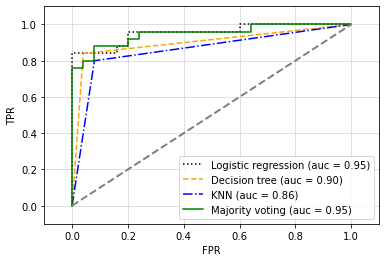

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange','blue','green']
lss = [':','--','-.','-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, lss):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, threosholds = roc_curve(y_true = y_test, y_score =y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color =clr, ls = ls, label = '%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], ls = '--', c='gray', lw = 2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha = 0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

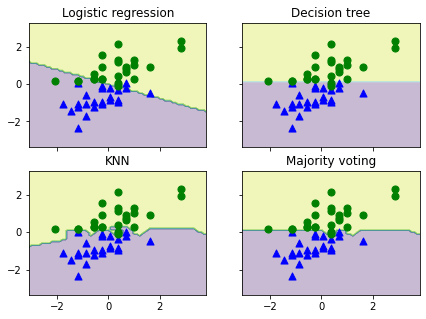

In [14]:
# 결정경계

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

x_min = X_train_std[:,0].min()-1
x_max = X_train_std[:,0].max()+1
y_min = X_train_std[:,1].min()-1
y_max = X_train_std[:,1].max()+1

xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                    np.arange(y_min,y_max,0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(7,5))

for idx, clf, tt in zip(product([0,1],[0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==0,0],
                                 X_train_std[y_train==0,1],
                                 color='blue',
                                 marker='^',
                                 s=50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==1,0],
                                 X_train_std[y_train==1,1],
                                 color='green',
                                 marker='o',
                                 s=50)
    axarr[idx[0],idx[1]].set_title(tt)
    
plt.show()

In [15]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf',
                  LogisticRegression(C=0.001, random_state=1,
                                     solver='liblinear')]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1, solver='liblinear')]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1, solver='liblinear'),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf_

 ## 배깅
 
 * 배깅은 앙상블에 있는 개별 분류기를 동일한 훈련 세트로 학습하는 것이 아니라 원본 훈련 세트에서 부트스트랩 샘플(중복을 허용한 랜덤 샘플)을 뽑아서 사용한다.
 
* 작동 방식
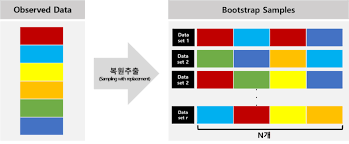

In [18]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                        '/wine/wine.data', header = None)
df_wine.columns = ['Class label','Alcohol','Malid acid', 'Ash',
                  'Alcalinity of ash','Magnesium','Total phenols',
                  'Flavanoids', 'Nonflavanoid phenols',
                  'Proanthocyanins','Color intensity','Hue',
                  'OD280/OD315 of diluted wines', 'Proline']

df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,
                                                stratify=y)


In [21]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                             random_state=1,
                             max_depth =None)

bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1,
                       random_state=1)

In [22]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 : %.3f/%.3f' % (tree_train, tree_test))
# 과대적합

결정 트리의 훈련 정확도/테스트 정확도 : 1.000/0.833


In [24]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('배깅의 훈련 정확도/테스트 정확도 : %.3f/%.3f' % (bag_train, bag_test))

배깅의 훈련 정확도/테스트 정확도 : 1.000/0.917


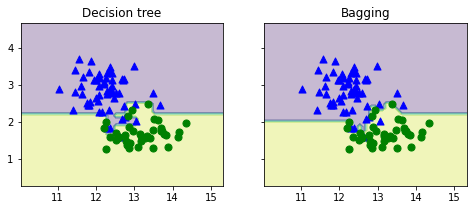

In [27]:
# 결정경계
x_min = X_train[:,0].min()-1
x_max = X_train[:,0].max()+1
y_min = X_train[:,1].min()-1
y_max = X_train[:,1].max()+1

xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                    np.arange(y_min,y_max,0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(8,3))

for idx, clf, tt in zip([0,1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],
                                 X_train[y_train==0,1],
                                 color='blue',
                                 marker='^',
                                 s=50)
    axarr[idx].scatter(X_train[y_train==1,0],
                                 X_train[y_train==1,1],
                                 color='green',
                                 marker='o',
                                 s=50)
    axarr[idx].set_title(tt)
    
plt.show()